In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from src.simple_models import SIRD
from src.stratified_models import stratified_SIRD
from src.load_data import load_italian_data

# Comparison between SIR and stratified SIR
The two curves must coincide in the example shown below

In [3]:
pred_SIRD = SIRD(beta0 = 0.16, 
                gamma=0.04, 
                tau=56, 
                fatality_rate_perc = 1, 
                N=60*10**6, 
                I0=50000, 
                R0=0, 
                D0=0)[4]

pred_stratified_SIRD = np.sum(stratified_SIRD(beta0 = 0.16, 
                                             gamma=0.04, 
                                             tau=56, 
                                             fatality_rates_perc=[1, 1, 1, 1], 
                                             N= [15*10**6, 15*10**6, 15*10**6, 15*10**6],
                                             I0 = 50000*np.array([1/4, 1/4, 1/4, 1/4]),
                                             R0 = [0, 0, 0, 0], 
                                             D0 = [0, 0, 0, 0])[4], axis=0)

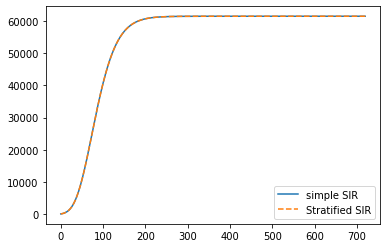

In [4]:
plt.plot(pred_SIRD, label='simple SIR')
plt.plot(pred_stratified_SIRD, label='Stratified SIR', linestyle='--')
plt.legend()
plt.show()

# Use the stratified SIR to model the italian 2nd wave

### Load data

In [5]:
data_casi, data_inf, data_rec, data_dec = load_italian_data()

# we only consider the 2nd wave
time = [220, 360]
data_casi = data_casi[time[0]:time[1]]
data_inf  = data_inf[time[0]:time[1]]
data_rec  = data_rec[time[0]:time[1]]
data_dec  = data_dec[time[0]:time[1]]

Distribution of italian population for different age groups.

Namely: 12-29, 30-49, 50-69, over 70 (see https://www.governo.it/it/cscovid19/report-vaccini/)

In [6]:
abitanti = np.array([4627514 + 6013709,
                     6794332 + 8795919,
                     9651541 + 7533486,
                     6019293 + 4554107])

abitanti_distro = abitanti/np.sum(abitanti)

Deaths declared by ISTAT due to Covid from the beginning of the epidemic. This information is relevant to understand how the mortality is distributed

In [7]:
# over 70
print('over 70:           ', 29488 + 48624 + 23418)

# 50-70 yeras old
print('50-70 years old:    ', 11728 + 4019)

# under 50
print('under 50:            ', 1016)

decessi_totali = np.array([0, 1016, 15747, 101530])
decessi_distro = decessi_totali/np.sum(decessi_totali)

over 70:            101530
50-70 years old:     15747
under 50:             1016


fatality rates, for the considered age groups, are taken from:
https://github.com/mbevand/covid19-age-stratified-ifr

In [8]:
fatality_rates = np.array([0.005, 0.05, 0.7, 5])

### define a minimizer to find the best parameters of the stratified SIR model

In [9]:
# define a function to minimize the distance between data and predictions

def to_minimize(X, verbose=False):
    beta0 = X[0]
    gamma = X[1]
    tau = X[2]
    f_scale = X[3]

    ll = len(data_inf)

    parz_results = stratified_SIRD(beta0 = beta0, 
                                  gamma = gamma,
                                  tau=tau,
                                  fatality_rates_perc = f_scale*fatality_rates,
                                  N = abitanti,
                                  I0 = data_inf[0]*abitanti_distro, 
                                  R0 = data_rec[0]*abitanti_distro,
                                  D0 = data_dec[0]*decessi_distro)
  
    S_pred = np.sum(parz_results[1], axis=0)[0:ll]
    I_pred = np.sum(parz_results[2], axis=0)[0:ll]
    R_pred = np.sum(parz_results[3], axis=0)[0:ll]
    D_pred = np.sum(parz_results[4], axis=0)[0:ll]

    obs  = np.array([np.sum(abitanti) - data_casi, data_inf, data_rec, data_dec])
    pred = np.array([S_pred, I_pred, R_pred, D_pred])
  
    err = np.sqrt(np.mean((obs - pred)**2/obs))

    if verbose == True:
        err_perc = round(np.mean(np.abs(obs-pred)/obs*100), 1)
        print('The average error of the model is ', err_perc, '%')
        return err_perc
    
    return err

from scipy.optimize import minimize
initial_params = [0.3, 1/30, 60, 2]
x_opt = minimize(to_minimize, initial_params, 
                 method='Nelder-Mead', options = {'disp':True, 'maxiter':1000})
X_opt = x_opt.x

avg_err = to_minimize(X_opt, verbose=True)

Optimization terminated successfully.
         Current function value: 73.766219
         Iterations: 238
         Function evaluations: 408
The average error of the model is  6.9 %


### compute model predictions

In [10]:
parz_results = stratified_SIRD(beta0=X_opt[0], 
               gamma=X_opt[1], 
               tau=X_opt[2],
               fatality_rates_perc = X_opt[3]*fatality_rates,
               N = abitanti,
               I0 = data_inf[0]*abitanti_distro, 
               R0 = data_rec[0]*abitanti_distro,
               D0 = data_dec[0]*decessi_distro)

S_pred = np.sum(parz_results[1], axis=0)
I_pred = np.sum(parz_results[2], axis=0)
R_pred = np.sum(parz_results[3], axis=0)
D_pred = np.sum(parz_results[4], axis=0)

### compare model with true data

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(S_pred, label='Model')
plt.plot(np.sum(abitanti) - data_casi, '.', markersize=2, label='Data')
plt.legend()
plt.grid()
plt.xlabel('Time (days)')
plt.title('Susceptible')
plt.xlim(0, 300)
plt.subplot(2, 2, 2)
plt.plot(I_pred, label='Model')
plt.plot(data_inf, '.', markersize=2, label='Data')
plt.legend()
plt.grid()
plt.xlabel('Time (days)')
plt.title('Active infected')
plt.xlim(0, 300)
plt.subplot(2, 2, 3)
plt.plot(R_pred, label='Model')
plt.plot(data_rec, '.', markersize=2, label='Data')
plt.legend()
plt.grid()
plt.xlabel('Time (days)')
plt.title('Recovered')
plt.xlim(0, 300)
plt.subplot(2, 2, 4)
plt.plot(D_pred, label='Model')
plt.plot(data_dec, '.', markersize=2, label='Data')
plt.legend()
plt.grid()
plt.xlabel('Time (days)')
plt.title('Deaths')
plt.xlim(0, 300)
plt.tight_layout()
plt.savefig('results/comparison_model_data.png', dpi=300)
plt.show()